## Exploratory Data Analysis

In [94]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division




import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [95]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [96]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<h3>RFM Scoring</h3>

<h4>Functions</h4>

In [97]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    sse={}
    columnDF = dataFrame[[column]]
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
    
def PerformKMeans(dataFrame, column, numClusters):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[[column]])
    clusterCol = '{0}Cluster'.format(column)
    clusters = kmeans.predict(dataFrame[[column]])
    
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
    
    
#function for ordering cluster numbers
def clustersInOrder(clusterName, targetName, dataFrame, ascending):
    
    #Set New Labels on Clusters, 0-max in order of mean targetName Value
    df_new = dataFrame.groupby(clusterName)[targetName].mean().reset_index()
    df_new = df_new.sort_values(by=targetName,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    #Set New Labels of Clusters to 
    df_final = pd.merge(dataFrame,df_new[[clusterName,'index']], on=clusterName)
    df_final = df_final.drop([clusterName],axis=1)
    df_final = df_final.rename(columns={"index":clusterName})
    
    return df_final

<h3>Buyers</h3>

<h4>Recency</h4>

count    94467.000000
mean       241.859888
std        152.702590
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Recency, dtype: float64


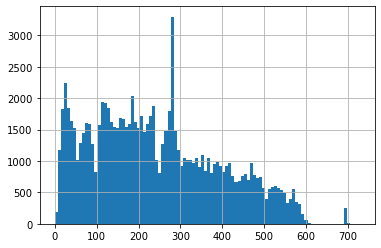

In [98]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Recency']])

print(buyers['Recency'].describe())
buyers.Recency.sort_values().hist(bins=100)
plt.show()


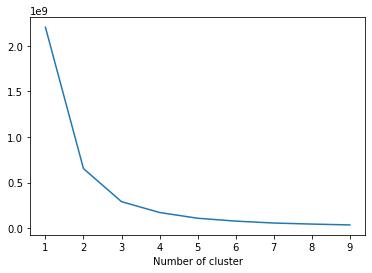

In [99]:
PrintKmeansInertiaGraph(buyers,'Recency')

In [100]:
#Generate Recency Clusters, named 'RecencyCluster'
PerformKMeans(buyers,'Recency', 4)

#Reset Cluster Names, Lower Recency = More Recent, Higher RecencyCluster
buyers = clustersInOrder('RecencyCluster', 'Recency', buyers, False)

count    94467.000000
mean         1.061005
std          0.289504
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Frequency, dtype: float64


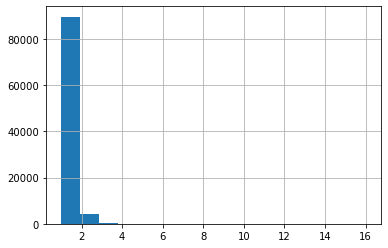

In [101]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Frequency'].describe())
buyers.Frequency.sort_values().hist(bins=16)
plt.show()

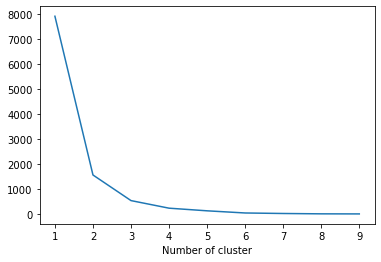

In [102]:
PrintKmeansInertiaGraph(buyers,'Frequency')

In [103]:
#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(buyers,'Frequency', 4)

#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
buyers = clustersInOrder('FrequencyCluster', 'Frequency', buyers, True)

count    94467.000000
mean       182.890726
std        306.673979
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Revenue, dtype: float64


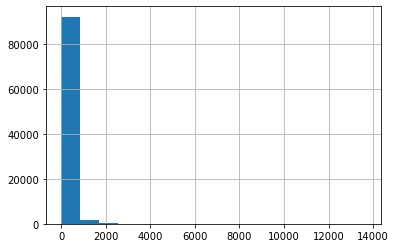

In [104]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Revenue'].describe())
buyers.Revenue.sort_values().hist(bins=16)
plt.show()

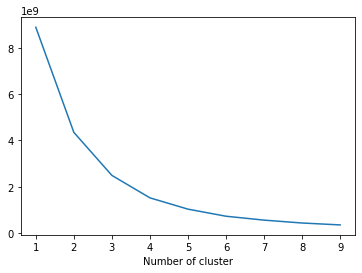

In [105]:
PrintKmeansInertiaGraph(buyers,'Revenue')

In [106]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(buyers,'Revenue', 5)

#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
buyers = clustersInOrder('RevenueCluster', 'Revenue', buyers, True)

In [107]:
#calculate overall score and use mean() to see details
buyers['OverallScore'] = buyers['RecencyCluster'] + buyers['FrequencyCluster'] + buyers['RevenueCluster']
print(buyers.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean())

print(buyers.groupby('OverallScore')[['Revenue']].count())

                 Recency  Frequency      Revenue
OverallScore                                    
0             486.682999   1.000000    97.432983
1             336.713072   1.012016   124.378070
2             213.112193   1.029643   146.958005
3              98.028162   1.046313   171.307269
4             110.637740   1.282644   467.856357
5             109.948816   1.681382   877.314037
6             104.713733   2.195358  1467.175919
7             102.077922   2.863636  2442.958247
8              86.765957   4.234043  3300.630000
9              72.200000   4.200000  4236.235000
              Revenue
OverallScore         
0               13552
1               21887
2               26178
3               25673
4                4886
5                1563
6                 517
7                 154
8                  47
9                  10


In [108]:
buyers['RFM_Ranking'] = 'Lowest'
buyers.loc[buyers['OverallScore']>=1,'RFM_Ranking'] ='Low' 
buyers.loc[buyers['OverallScore']>=3, 'RFM_Ranking'] = 'Medium'
buyers.loc[buyers['OverallScore']>=6, 'RFM_Ranking'] = 'High'
buyers.loc[buyers['OverallScore']>=8, 'RFM_Ranking'] = 'Highest'

count    2977.000000
mean      134.126638
std       163.831359
min         0.000000
25%        17.000000
50%        46.000000
75%       210.000000
max       699.000000
Name: Recency, dtype: float64


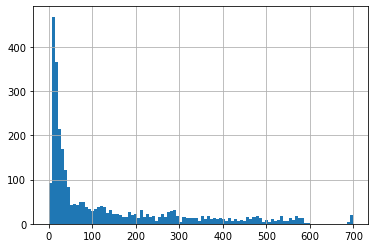

In [83]:
#Recency Score Calc
sellers = pd.DataFrame(OL_Data['seller_id'].unique())
sellers.columns=['SellerID']

sellerMaxSale = OL_Data.groupby('seller_id').order_purchase_timestamp.max().reset_index()
sellerMaxSale.columns = ['SellerID', 'MaxSaleDate']

sellerMaxSale['Recency'] = (sellerMaxSale['MaxSaleDate'].max() - sellerMaxSale['MaxSaleDate']).dt.days

sellers = pd.merge(sellers, sellerMaxSale[['SellerID','Recency']])

print(sellers['Recency'].describe())
sellers.Recency.sort_values().hist(bins=100)
plt.show()

count    2977.000000
mean       33.667786
std       108.081772
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1865.000000
Name: Frequency, dtype: float64


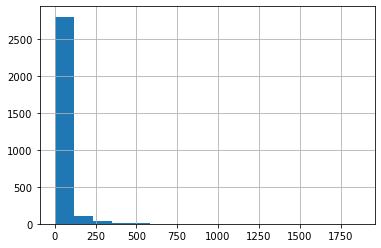

In [84]:
#Frequency
freq = OL_Data.groupby('seller_id').order_id.count().reset_index()
freq.columns = ['SellerID','Frequency']
freq.head()

sellers = pd.merge(sellers,freq, on='SellerID')

print(sellers['Frequency'].describe())
sellers.Frequency.sort_values().hist(bins=16)
plt.show()

count      2977.000000
mean       5803.513779
std       17929.475314
min          15.220000
25%         315.440000
50%        1164.380000
75%        4533.870000
max      301542.650000
Name: Revenue, dtype: float64


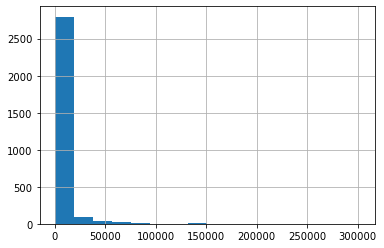

In [86]:
#Revenue
rev = OL_Data.groupby('seller_id').Total_payment.sum().reset_index()
rev.columns = ['SellerID','Revenue']

sellers = pd.merge(sellers, rev, on='SellerID')

print(sellers['Revenue'].describe())
sellers.Revenue.sort_values().hist(bins=16)
plt.show()

Recency


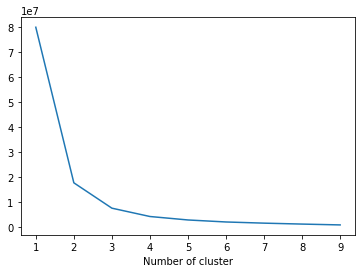


Frequency


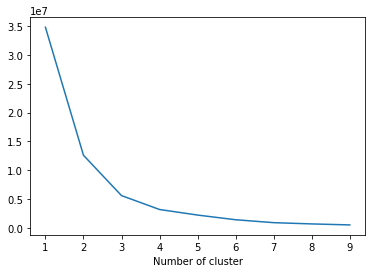


Revenue


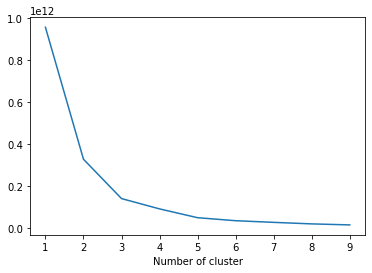

In [90]:
print('Recency')
PrintKmeansInertiaGraph(sellers,'Recency')
print('')
print('Frequency')
PrintKmeansInertiaGraph(sellers,'Frequency')
print('')
print('Revenue')
PrintKmeansInertiaGraph(sellers,'Revenue')

In [109]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Recency', 4)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('RecencyCluster', 'Recency', sellers, True)

#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(sellers,'Frequency', 4)
#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
sellers = clustersInOrder('FrequencyCluster', 'Frequency', sellers, True)

#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Revenue', 5)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('RevenueCluster', 'Revenue', sellers, True)

In [110]:
#calculate overall score and use mean() to see details
sellers['OverallScore'] = sellers['RecencyCluster'] + sellers['FrequencyCluster'] + sellers['RevenueCluster']
print(sellers.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean())

print(sellers.groupby('OverallScore')[['Revenue']].count())

                 Recency    Frequency        Revenue
OverallScore                                        
0              30.334789    12.473071    1943.584010
1             121.449074    19.699074    4426.794753
2             224.792043    42.314647    6587.820561
3             442.307918    36.498534    7078.310557
4              75.342105   345.815789   49082.791579
5              80.400000   557.900000  114049.226000
6               7.375000  1187.125000  175086.316250
7              10.600000  1252.600000  254983.110000
              Revenue
OverallScore         
0                1374
1                 648
2                 553
3                 341
4                  38
5                  10
6                   8
7                   5


In [111]:
sellers['RFM_Ranking'] = 'Lowest'
sellers.loc[sellers['OverallScore']>=1,'RFM_Ranking'] ='Low' 
sellers.loc[sellers['OverallScore']>=4, 'RFM_Ranking'] = 'Medium'
sellers.loc[sellers['OverallScore']>=6, 'RFM_Ranking'] = 'High'